In [2]:
import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import random


import os

In [3]:
# get the dataset
cwd = os.getcwd()

train_data = pd.read_csv(cwd + "/dataset/train.csv")
test_data = pd.read_csv(cwd + "/dataset/test.csv")

<Axes: xlabel='target', ylabel='count'>

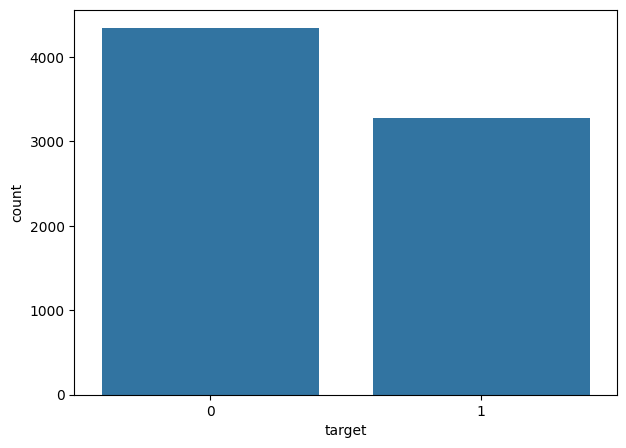

In [4]:
# visualize the balance of target
fig = plt.figure(figsize=(7,5))
sns.countplot(x="target",data=train_data)

In [5]:
print(f'The shape of the dataset is : {train_data.shape}')
print(f'The columns are :{train_data.columns}')
print(f'The dtypes of the dataset : \n\n{train_data.dtypes}')

The shape of the dataset is : (7613, 5)
The columns are :Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
The dtypes of the dataset : 

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object


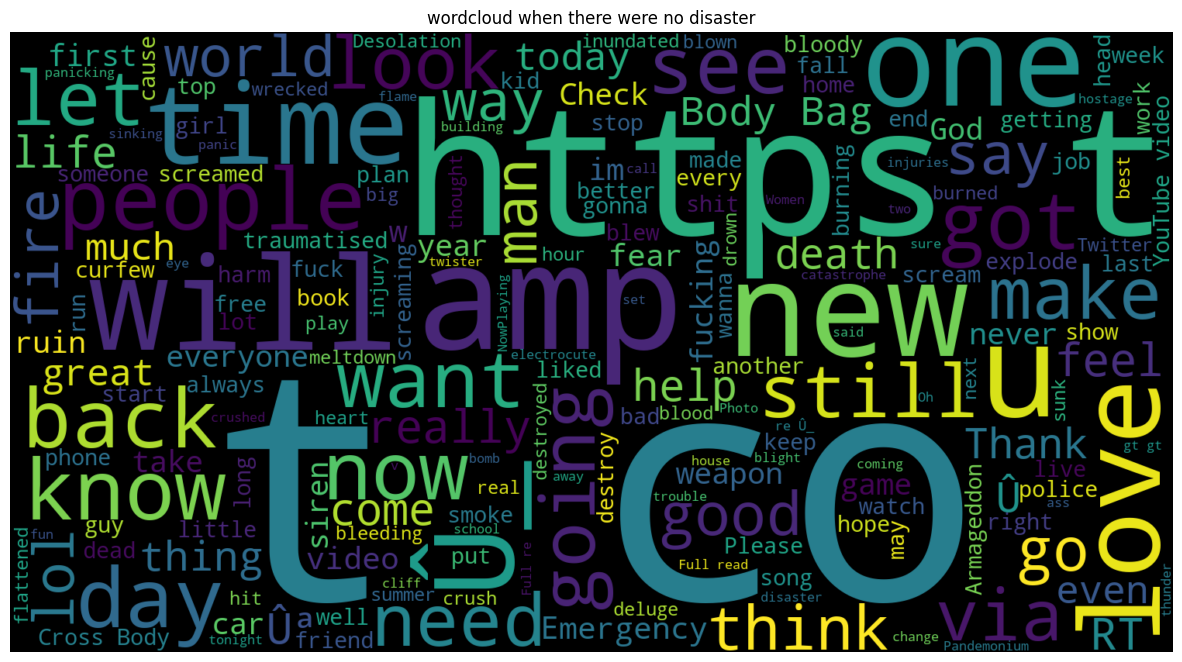

In [6]:
from wordcloud import WordCloud
text = " ".join(i for i in train_data[train_data['target'] == 0 ]['text'])
wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                          min_font_size=15).generate(text)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('wordcloud when there were no disaster')
plt.show()

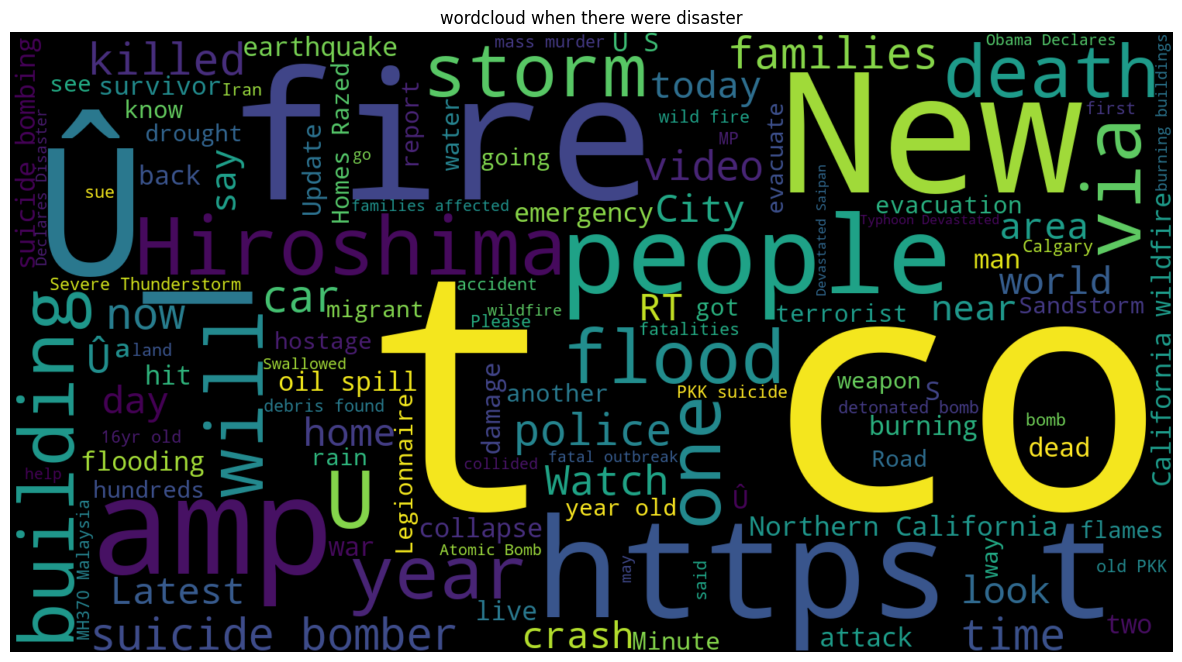

In [7]:
text = " ".join(i for i in train_data[train_data['target'] == 1 ]['text'])
wordcloud = wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                          min_font_size=15).generate(text)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('wordcloud when there were disaster')
plt.show()

In [8]:
def show_details(dataset):
    missed_values = dataset.isnull().sum()
    missed_values_percent = (dataset.isnull().sum()) / len(dataset)
    duplicated_values = dataset.duplicated().sum()
    duplicated_values_percent = (dataset.duplicated().sum()) / len(dataset)
    info_frame = pd.DataFrame({'Missed_Values' : missed_values , 
                              'Missed_Values %' :missed_values_percent,
                              'Duplicated values' :duplicated_values,
                              'Duplicated values %':duplicated_values_percent})
    return info_frame.T

In [9]:
show_details(train_data)

,id,keyword,location,text,target
Missed_Values,0.0,61.000000,2533.00000,0.0,0.0
Missed_Values %,0.0,0.008013,0.33272,0.0,0.0
Duplicated values,0.0,0.000000,0.00000,0.0,0.0
Duplicated values %,0.0,0.000000,0.00000,0.0,0.0


In [10]:
show_details(test_data)

,id,keyword,location,text
Missed_Values,0.0,26.000000,1105.000000,0.0
Missed_Values %,0.0,0.007968,0.338645,0.0
Duplicated values,0.0,0.000000,0.000000,0.0
Duplicated values %,0.0,0.000000,0.000000,0.0


As expected from the dataset information, there are some missing values for both keyword and location. For this approach, we can ignore this because we will not be using either keyword or location.

### Clean the train and test data
to reduce the noise from the data, clean the data from uppercase, emojis, punctuation, etc.

In [11]:
train_data['clean_text'] = train_data['text'].str.replace(' &amp;', ' and')
test_data['clean_text'] = test_data['text'].str.replace('&amp;', ' and')
train_data['clean_text'].loc[67]

"'I can't have kids cuz I got in a bicycle accident and split my testicles. it's impossible for me to have kids' MICHAEL YOU ARE THE FATHER"

##### Normalizing text
turn both data to lowercase

In [12]:
train_data['clean_text'] = train_data['clean_text'].str.lower()
test_data['clean_text'] = test_data['clean_text'].str.lower()


##### Remove Unicode Characters

In [13]:
train_data['clean_text'] = [re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", str(x)) for x in train_data['clean_text']]
test_data['clean_text'] = [re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", str(x)) for x in test_data['clean_text']]

##### Tokenization

In [14]:
#use tweet tokenizer
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()

train_data['tokenized_text'] = train_data['clean_text'].apply(lambda x : tokenizer.tokenize(x))
test_data['tokenized_text'] = test_data['clean_text'].apply(lambda x : tokenizer.tokenize(x))
train_data['tokenized_text'][67]

['i',
 'cant',
 'have',
 'kids',
 'cuz',
 'i',
 'got',
 'in',
 'a',
 'bicycle',
 'accident',
 'and',
 'split',
 'my',
 'testicles',
 'its',
 'impossible',
 'for',
 'me',
 'to',
 'have',
 'kids',
 'michael',
 'you',
 'are',
 'the',
 'father']

In [15]:
train_data.head()

,id,keyword,location,text,target,clean_text,tokenized_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala..."


##### Remove Stopwords and Apply Lemmatization

In [16]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexmatei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download("wordnet")

def stopwords_cleaner(text):
    word = [lemmatizer.lemmatize(letter) for letter in text if letter not in stop]
    peasting = ' '.join(word)
    return peasting

train_data['tokenized_text'] = train_data['tokenized_text'].apply(lambda x : stopwords_cleaner(x))
test_data['tokenized_text'] = test_data['tokenized_text'].apply(lambda x : stopwords_cleaner(x))

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alexmatei/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
train_data.head()

,id,keyword,location,text,target,clean_text,tokenized_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,resident asked shelter place notified officer ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,got sent photo ruby alaska smoke wildfire pour...


In [19]:
test_data.head()

,id,keyword,location,text,clean_text,tokenized_text
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard about earthquake is different cities sta...,heard earthquake different city stay safe ever...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...,forest fire spot pond goose fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,apocalypse lighting spokane wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 in china and taiwan,typhoon soudelor kill 28 china taiwan


## Revisualized the wordcloud

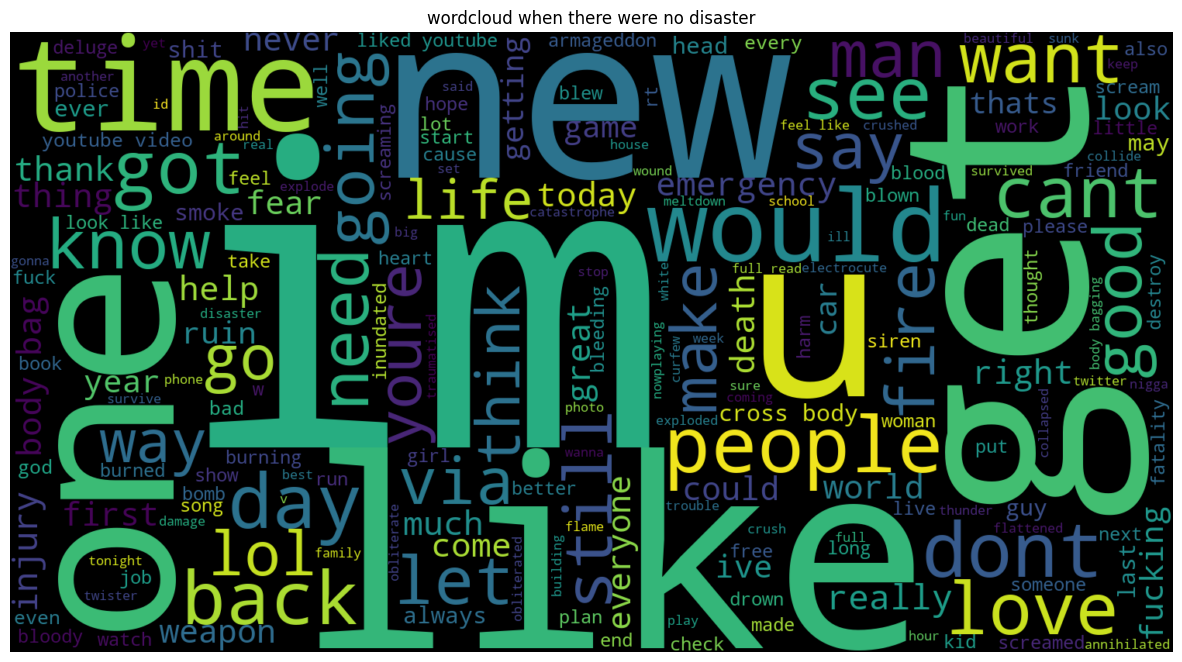

In [20]:
text = " ".join(i for i in train_data[train_data['target'] == 0 ]['tokenized_text'])
wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                          stopwords=stop,
                          min_font_size=15).generate(text)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('wordcloud when there were no disaster')
plt.show()


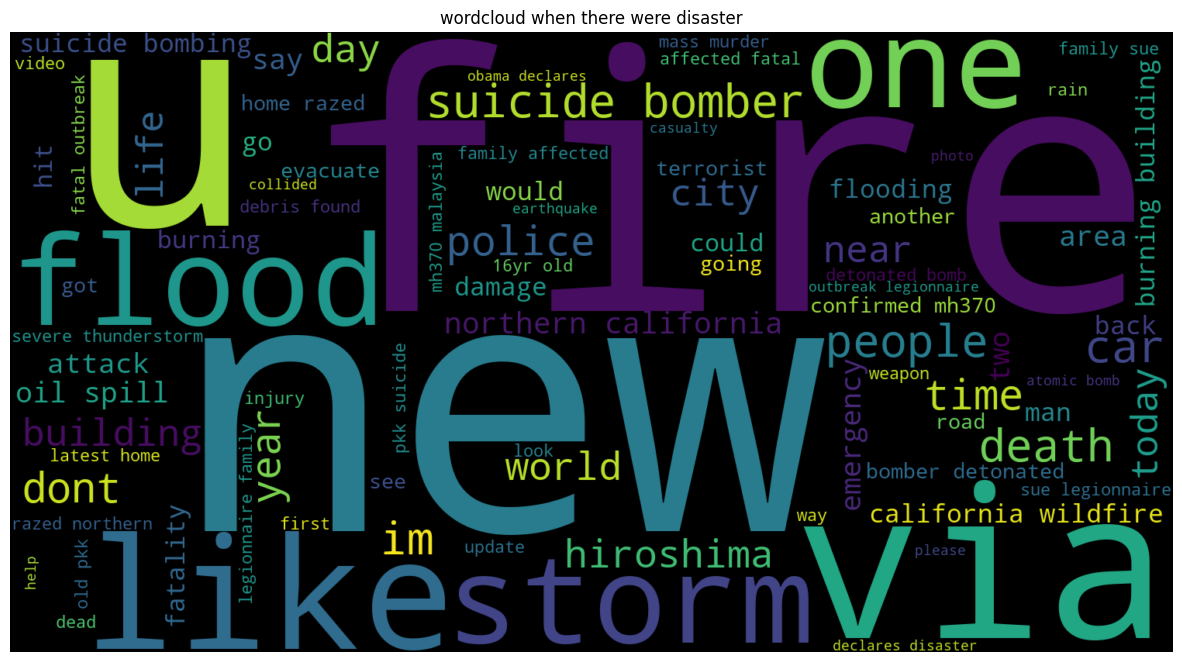

In [21]:
text = " ".join(i for i in train_data[train_data['target'] == 1 ]['tokenized_text'])
wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                          stopwords=stop,
                          min_font_size=15).generate(text)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('wordcloud when there were disaster')
plt.show()

text = " ".join(i for i in train_data[train_data['target'] == 0 ]['tokenized_text'])
wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                          stopwords=stop,
                          min_font_size=15).generate(text)

In [22]:
# the shape must be the same for both x and y if we're going to use train_test_split
x = train_data["text"]
print()
y = train_data["target"]
print(x.shape, y.shape)



(7613,) (7613,)


In [23]:
from sklearn.model_selection import train_test_split 

#before vectorizing, split the train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=41)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
type(x)

(5709,) (1904,) (5709,) (1904,)


pandas.core.series.Series

# Create a machine learning model

We'll use sklearn's Tfidf vectorizer. This has the advantage of applying a
term-frequency times inverse document-frequency transformation to the vectorized
data, which gives less weight to tokens that appear more frequently in a given
corpus.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

# check the shapes of the training data
print(x_train.shape, y_train.shape)

(5709, 17704) (5709,)


Using Naive Bayes and Logistic Regression

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm

NBClass = MultinomialNB()
NBClass.fit(x_train, y_train)
y_predNB = NBClass.predict(x_test)

LGClass = LogisticRegression()
LGClass.fit(x_train, y_train)
y_predLG = LGClass.predict(x_test)

SVMClass = svm.SVC()
SVMClass.fit(x_train, y_train)
y_predSVM = SVMClass.predict(x_test)

type(y_predLG)

numpy.ndarray

## Reporting


In [27]:
from sklearn import metrics

def print_report(name : str, clf : object, preds : object) -> None:
    accuracy = metrics.accuracy_score(y_test, preds)
    print(f"{name} Accuracy: {accuracy}")
    
    # Print the classification report for each class
    classification_report = metrics.classification_report(y_test, preds)
    print(f"{name} Classification Report:\n{classification_report}")

In [28]:
print_report("Naive Bayes", NBClass, y_predNB)
print_report("Logistic Regression", LGClass, y_predLG)

Naive Bayes Accuracy: 0.8172268907563025
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.94      0.86      1099
           1       0.89      0.65      0.75       805

    accuracy                           0.82      1904
   macro avg       0.84      0.80      0.80      1904
weighted avg       0.83      0.82      0.81      1904

Logistic Regression Accuracy: 0.8088235294117647
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1099
           1       0.80      0.73      0.76       805

    accuracy                           0.81      1904
   macro avg       0.81      0.80      0.80      1904
weighted avg       0.81      0.81      0.81      1904



In [ ]:
#Vectorize the validation data
x_valid = test_data['text']
x_valid = vectorizer.transform(x_valid)
y_predNB = NBClass.predict(x_valid)
print(y_predNB)


[0 0 1 ... 1 1 1]


Write to submission file. Make sure to select the desired model's output for submission. Uncomment when ready to print.

In [ ]:
# output = pd.DataFrame({'id': test_data.id, 'target': y_predNB})
# output.to_csv('submission.csv', index=False)
# print("Submission file generated in " + cwd)

Submission file generated in /Users/alexmatei/git/nlp-disaster
